In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
df = pd.read_csv('Fraud.csv')

In [15]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [16]:
df = df.rename(columns={'nameOrig':'nameorig','oldbalanceOrg':'oldbalanceorig','newbalanceOrig':'newbalanceorig','nameDest':'namedest'
    ,'oldbalanceDest':'oldbalancedest','newbalanceDest':'newbalancedest'})
df.columns

Index(['step', 'type', 'amount', 'nameorig', 'oldbalanceorig',
       'newbalanceorig', 'namedest', 'oldbalancedest', 'newbalancedest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [17]:
df.isnull().sum()

step              0
type              0
amount            0
nameorig          0
oldbalanceorig    0
newbalanceorig    1
namedest          1
oldbalancedest    1
newbalancedest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

### Multi-collinearity -

In [11]:
df1 = df.copy(deep = 'true')
df1['type']=df1['type'].map({'PAYMENT':1 ,'TRANSFER':2, 'CASH_OUT':3, 'DEBIT':4, 'CASH_IN':5})
df1 = df1.drop(columns = ['nameorig','namedest','isFraud','isFlaggedFraud'])
df1.head()

,step,type,amount,oldbalanceorig,newbalanceorig,oldbalancedest,newbalancedest
0,1,1,9839.64,170136.0,160296.36,0.0,0.0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0
2,1,2,181.00,181.0,0.00,0.0,0.0
3,1,3,181.00,181.0,0.00,21182.0,0.0
4,1,1,11668.14,41554.0,29885.86,0.0,0.0


In [9]:
print('Type of transaction which are fraud:{}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

fraud_transfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
fraud_cashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]


print('number of transfer are fraud :{}'.format(len(fraud_transfer)))
print('number of cashout are fraud :{}'.format(len(fraud_cashout)))



Type of transaction which are fraud:['TRANSFER', 'CASH_OUT']
number of transfer are fraud :928
number of cashout are fraud :942


In [11]:


print('numebr of recipant who have newbalancedest and oldbalancedest is zero :{}'
      .format(len(df.loc[(df.newbalancedest == 0) & (df.oldbalancedest == 0) ].namedest.values)))


numebr of recipant who have newbalancedest and oldbalancedest is zero :658135


In [12]:
zero_balance = list(df.loc[(df.oldbalanceorig == 0) & (df.newbalanceorig == 0) & (df.amount != 0)].type.values)

print('Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :{}'.format(len(zero_balance)))

Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :605544


In [13]:
print('number of merchants in originator transaction: {}' .format(df.nameorig.str.contains('M').any()))
print('number of merchant acoount in destination where type is Transfer : {}' .format(df.loc[df.type =='TRANSFER'].namedest.str.contains('M').any()))
print('number of merchant acoount in destination where type is cashout : {}' .format(df.loc[df.type =='CASH_OUT'].namedest.str.contains('M').any()))

number of merchants in originator transaction: False
number of merchant acoount in destination where type is Transfer : False
number of merchant acoount in destination where type is cashout : False


In [14]:
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
y = x.isFraud
x = x.drop(['isFraud','isFlaggedFraud','nameorig','namedest'],axis = 1)
x['type']= x['type'].map({'TRANSFER':1,'CASH_OUT':2})

In [15]:
x.loc[(x.oldbalancedest == 0) & (x.newbalancedest == 0) & (x.amount != 0) ,['oldbalancedest','newbalancedest'] ] = -1
x.loc[(x.oldbalanceorig == 0) & (x.newbalanceorig == 0) & (x.amount != 0) ,['oldbalanceorig','newbalanceorig'] ] = 0

#imputing missing values

In [16]:
x['errorbalanceorig'] = x.newbalanceorig + x.amount - x.oldbalanceorig   # eg origin- oldbal = 10 ,newbal = 8 ,amount = 2 so, error =  8+2-10 = 0
x['errorbalancedest'] = x.oldbalancedest + x.amount - x.newbalancedest   #eg - at dest its opposite , old bal = 8 ,new bal = 10 , amount = 2 :error = 8+2-10 = 0

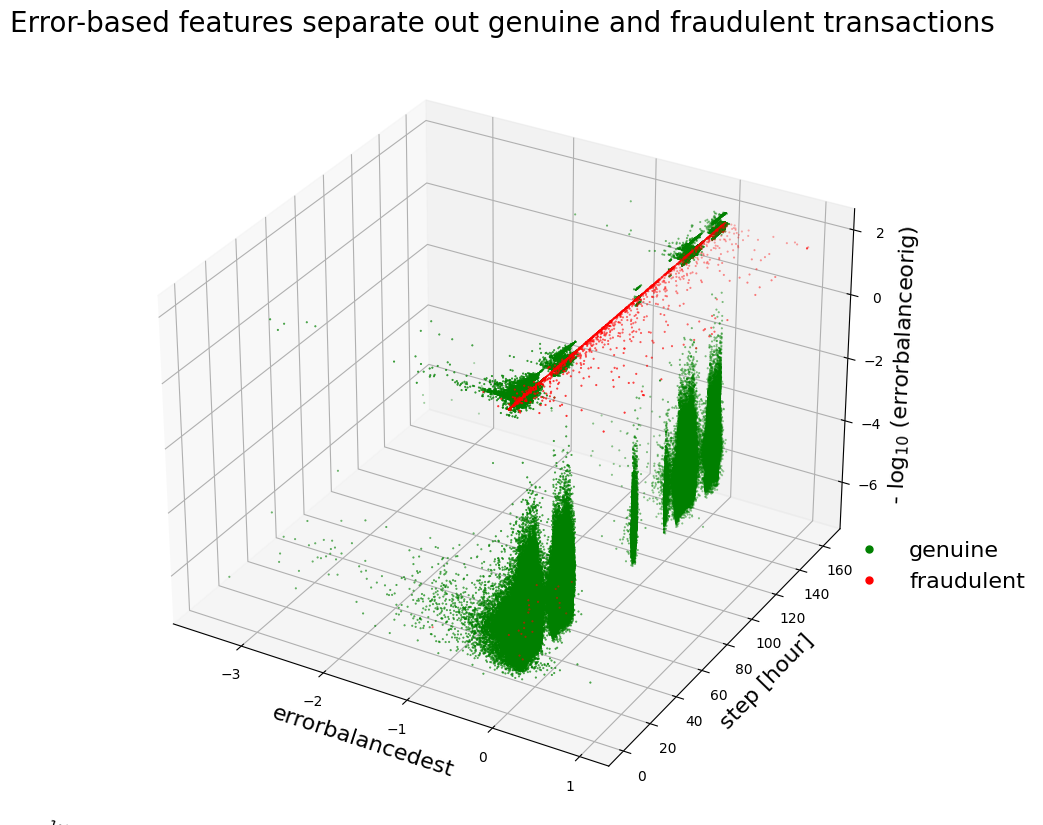

In [17]:
x1 = 'errorbalancedest'
y1 = 'step'
z1= 'errorbalanceorig'
zOffset = 0.02
limit = len(x)

sns.reset_orig()

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x.loc[y == 0, x1][:limit], x.loc[y == 0, y1][:limit], \
  -np.log10(x.loc[y == 0, z1][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')

ax.scatter(x.loc[y == 1, x1][:limit], x.loc[y == 1, y1][:limit], \
  -np.log10(x.loc[y == 1, z1][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x1, size = 16);
ax.set_ylabel(y1 + ' [hour]', size = 16);
ax.set_zlabel('- log$_{10}$ (' + z1 + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

In [18]:
xfraud = x.loc[y==1]
xnotfraud = x.loc[y == 0]

print(len(xfraud))
print(len(xnotfraud))

1870
813193


In [19]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=27)

In [20]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())                  #xgb uses the scale_pos_weight to account for highly skewed datset
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights,
                n_jobs = 4)
probabilities = clf.fit(X_train,y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(y_test, probabilities[:, 1])))

AUPRC = 0.9945810993376659


Average precision score (AUPRC) is a metric commonly used in imbalanced classification tasks, like fraud detection, where the number of positive (fraudulent) examples is much smaller than the number of negative (genuine) examples. AUPRC takes into account both precision and recall, making it a suitable metric for imbalanced datasets.

The AUPRC value you obtained (0.994) indicates that your XGBoost model has very high precision and recall, and it is performing exceptionally well in distinguishing between genuine and fraudulent transactions.

Importing Libraries: The code starts by importing necessary libraries like pandas, numpy, matplotlib, seaborn, statsmodels, and sklearn.

Loading the Data: The code loads the fraud detection dataset from a CSV file named 'Fraud.csv' into a pandas DataFrame called df.

Data Preprocessing: The code performs some initial data preprocessing tasks, such as renaming columns and handling missing values.

Exploratory Data Analysis (EDA): The code then performs exploratory data analysis, printing information about the dataset, and analyzing the number of fraudulent transactions for each transaction type.

Preparing Data for Model Training: The code prepares the data for model training by creating a new DataFrame x, containing the features (independent variables) and the target variable y indicating whether a transaction is fraudulent (1) or not (0).

Feature Engineering: The code creates additional features such as errorbalanceorig and errorbalancedest, which represent the error between old and new balances for the originator and destination accounts.

Data Visualization: The code creates a 3D scatter plot to visualize how the error-based features separate genuine and fraudulent transactions.

Splitting Data into Train and Test Sets: The code splits the data into training and testing sets using the train_test_split function from sklearn.

Handling Class Imbalance: Since fraud detection datasets often have class imbalances (fewer fraud cases than genuine cases), the code calculates the class weights to be used in the XGBoost model to address this issue.

Training the XGBoost Model: The code creates an XGBoost classifier (XGBClassifier) and fits it to the training data using fit. It also predicts probabilities of fraud (predict_proba) for the test data.

Evaluating the Model: The code calculates the average precision score (average_precision_score) as the evaluation metric for the XGBoost model.

In summary, this code performs fraud detection analysis using the XGBoost algorithm. It preprocesses the data, engineers additional features, visualizes the data, trains an XGBoost model, and evaluates its performance using the average precision score. The high AUPRC value (0.99) indicates that the model is performing well in detecting fraudulent transactions in the dataset.